In [8]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import pandas as pd
import time

# 1. 브라우저 옵션 설정
options = Options()
# options.add_argument('--headless') # 창을 띄우지 않으려면 주석 해제

# 드라이버 매니저 없이 최신 셀레니움 기능을 사용합니다.
driver = webdriver.Chrome(options=options) 

all_data = []

try:
    url = "https://www.koreabaseball.com/Record/Player/Runner/Basic.aspx"
    driver.get(url)
    time.sleep(3) # 인터넷 속도에 따라 충분히 대기

    # 2. 1페이지부터 5페이지까지 반복
    for page_num in range(1, 6):
        print(f"현재 {page_num}페이지 수집 중...")
        
        # 현재 페이지 데이터 읽기
        html = driver.page_source
        dfs = pd.read_html(html)
        if dfs:
            all_data.append(dfs[0])

        # 다음 페이지 클릭 (마지막 페이지가 아닐 때만)
        if page_num < 5:
            # 페이지 번호 버튼 찾기 (숫자가 page_num + 1인 버튼)
            try:
                # 다음 페이지 번호 텍스트를 가진 요소를 찾아 클릭
                next_page = driver.find_element(By.LINK_TEXT, str(page_num + 1))
                next_page.click()
                time.sleep(2) # 로딩 대기
            except:
                print(f"{page_num + 1}페이지 버튼을 찾을 수 없습니다.")
                break

    # 3. 데이터 통합
    total_df = pd.concat(all_data, ignore_index=True)
    print("--- 수집 완료! ---")
    print(total_df.head())
    
    # CSV 저장
    total_df.to_csv("KBO_Total_Runners.csv", index=False, encoding='utf-8-sig')

finally:
    driver.quit()

현재 1페이지 수집 중...
현재 2페이지 수집 중...
현재 3페이지 수집 중...
현재 4페이지 수집 중...
현재 5페이지 수집 중...
--- 수집 완료! ---
   순위  선수명   팀명    G  SBA  SB  CS   SB%  OOB  PKO
0   1  박해민   LG  144   63  49  14  77.8    5    0
1   2  김주원   NC  144   55  44  11  80.0    1    3
2   3  정준재  SSG  132   45  37   8  82.2    4    0
3   4  조수행   두산  108   37  30   7  81.1    3    1
4   4  최정원   NC   91   36  30   6  83.3    2    0


In [11]:
import pandas as pd

# 1. '팀' 컬럼이 'LG'인 행만 추출
lg_df = df[df['팀명'] == 'LG'].copy()

# 2. 데이터 전처리 (숫자형 변환)
# 크롤링한 데이터는 문자열(string)인 경우가 많아 계산을 위해 숫자로 바꿔야 합니다.
cols_to_convert = ['SBA', 'SB', 'CS']
for col in cols_to_convert:
    lg_df[col] = pd.to_numeric(lg_df[col], errors='coerce')

# 3. 새로운 지표 생성 (도루 성공률 직접 계산)
# 공식 홈페이지 데이터가 있더라도 직접 계산해보는 과정이 포트폴리오에 신뢰를 줍니다.
lg_df['Success_Rate'] = (lg_df['SB'] / lg_df['SBA']) * 100

# 4. 결과 확인 (도루 시도가 많은 순서대로 정렬)
lg_df_sorted = lg_df.sort_values(by='SBA', ascending=False)
print(lg_df_sorted[['선수명', '팀명', 'SBA', 'SB', 'CS', 'Success_Rate']].head(10))

    선수명  팀명  SBA  SB  CS  Success_Rate
0   박해민  LG   63  49  14     77.777778
20  신민재  LG   24  15   9     62.500000


--- 팀별 도루 집계 현황 ---
     SBA   SB  CS  SB_Rate
팀명                        
NC   249  190  59     76.3
두산   184  144  40     78.3
SSG  175  129  46     73.7
LG   169  121  48     71.6
삼성   129   98  31     76.0
한화   123   96  27     78.0
롯데   117   91  26     77.8
키움    85   74  11     87.1
KIA   82   67  15     81.7
KT    66   48  18     72.7


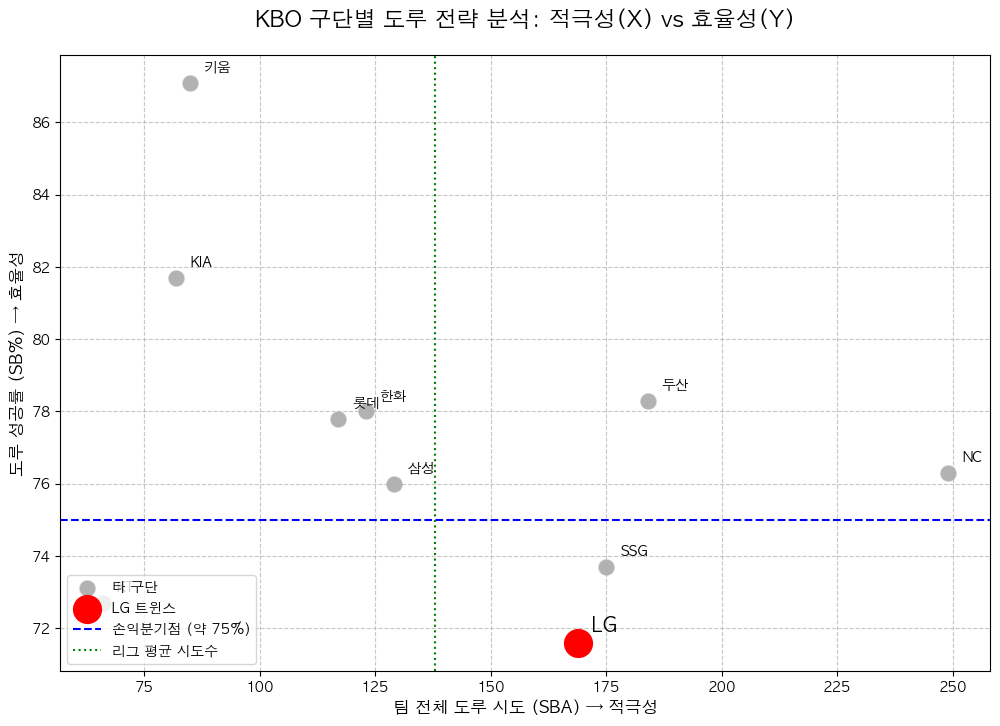

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================
# 1. 데이터 전처리: 선수 데이터를 팀 데이터로 변환
# =============================================

# 1-1. 숫자형으로 변환 (계산을 위해 필수)
cols_to_numeric = ['SBA', 'SB', 'CS']
for col in cols_to_numeric:
    # 혹시 모를 문자 오류를 대비해 errors='coerce' 사용
    total_df[col] = pd.to_numeric(total_df[col], errors='coerce')

# 1-2. 팀별로 그룹화하여 합계 구하기
team_df = total_df.groupby('팀명')[['SBA', 'SB', 'CS']].sum()

# 1-3. 팀별 도루 성공률(SB_Rate) 계산
# 성공률 = (성공 / 시도) * 100
team_df['SB_Rate'] = (team_df['SB'] / team_df['SBA']) * 100
team_df = team_df.round(1) # 소수점 첫째 자리까지만 표시

print("--- 팀별 도루 집계 현황 ---")
print(team_df.sort_values(by='SBA', ascending=False))


# =============================================
# 2. 시각화: LG vs 타팀 비교 산점도
# =============================================

# 2-1. 한글 폰트 설정 (Mac 기준)
# Windows 사용 시 'Malgun Gothic' 등으로 변경 필요
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

plt.figure(figsize=(12, 8)) # 그래프 크기 설정

# 2-2. 전체 팀 그리기 (배경색, 조금 작게)
# 텍스트 표시를 위해 기본 scatter plot 사용
sns.scatterplot(data=team_df, x='SBA', y='SB_Rate', 
                color='gray', s=150, alpha=0.6, label='타 구단')

# 2-3. LG 트윈스만 강조해서 그리기 (빨간색, 아주 크게)
lg_data = team_df.loc['LG']
plt.scatter(x=lg_data['SBA'], y=lg_data['SB_Rate'], 
            color='red', s=400, zorder=5, label='LG 트윈스')

# 2-4. 각 팀 이름 표시하기 (Annotation)
for team_name in team_df.index:
    # LG는 글씨도 좀 더 크게
    fontsize = 14 if team_name == 'LG' else 10
    fontweight = 'bold' if team_name == 'LG' else 'normal'
    
    plt.text(x=team_df.loc[team_name, 'SBA'] + 3,  # 점보다 약간 오른쪽에 표시
             y=team_df.loc[team_name, 'SB_Rate'] + 0.3, # 점보다 약간 위쪽에 표시
             s=team_name, 
             fontsize=fontsize, fontweight=fontweight)

# 2-5. 분석의 핵심: 손익분기점 가이드라인 추가 (산업공학 포인트!)
# 통계적으로 도루 성공률이 약 73~75% 이상이어야 득점 기대값이 플러스가 됩니다.
plt.axhline(y=75, color='blue', linestyle='--', linewidth=1.5, label='손익분기점 (약 75%)')
plt.axvline(x=team_df['SBA'].mean(), color='green', linestyle=':', label='리그 평균 시도수')


# 2-6. 그래프 꾸미기
plt.title('KBO 구단별 도루 전략 분석: 적극성(X) vs 효율성(Y)', fontsize=16, pad=20)
plt.xlabel('팀 전체 도루 시도 (SBA) → 적극성', fontsize=12)
plt.ylabel('도루 성공률 (SB%) → 효율성', fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [15]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select # 연도 선택을 위해 필요
import pandas as pd
import time

# 1. 브라우저 설정
options = Options()
driver = webdriver.Chrome(options=options)

all_2023_data = []

try:
    url = "https://www.koreabaseball.com/Record/Player/Runner/Basic.aspx"
    driver.get(url)
    time.sleep(2)

    # 2. 연도 선택 (2023년으로 변경)
    # KBO 사이트의 연도 선택 드롭다운 ID를 찾아 선택합니다.
    select_year = Select(driver.find_element(By.ID, "cphContents_cphContents_cphContents_ddlSeason_ddlSeason"))
    select_year.select_by_value("2023")
    time.sleep(2) # 연도 변경 후 로딩 대기

    # 3. 1페이지부터 5페이지까지 반복 수집
    for page_num in range(1, 6):
        print(f"2023 시즌 {page_num}페이지 수집 중...")
        
        # 현재 페이지 데이터 읽기
        html = driver.page_source
        dfs = pd.read_html(html)
        if dfs:
            all_2023_data.append(dfs[0])

        # 다음 페이지 클릭
        if page_num < 5:
            try:
                next_page = driver.find_element(By.LINK_TEXT, str(page_num + 1))
                next_page.click()
                time.sleep(2)
            except:
                break

    # 4. 전체 데이터 통합
    kbo_2023_all = pd.concat(all_2023_data, ignore_index=True)
    
    # 5. LG 선수 데이터만 따로 추출
    lg_2023_runners = kbo_2023_all[kbo_2023_all['팀명'] == 'LG'].copy()

    # 6. 결과 저장
    kbo_2023_all.to_csv("KBO_2023_All_Runners.csv", index=False, encoding='utf-8-sig')
    lg_2023_runners.to_csv("LG_2023_Runners.csv", index=False, encoding='utf-8-sig')
    
    print("\n--- 2023 시즌 수집 완료! ---")
    print(f"전체 선수: {len(kbo_2023_all)}명")
    print(f"LG 선수: {len(lg_2023_runners)}명")

finally:
    driver.quit()

2023 시즌 1페이지 수집 중...
2023 시즌 2페이지 수집 중...
2023 시즌 3페이지 수집 중...
2023 시즌 4페이지 수집 중...
2023 시즌 5페이지 수집 중...

--- 2023 시즌 수집 완료! ---
전체 선수: 150명
LG 선수: 16명


/var/folders/qb/hwn9hgks4kd86_pyz0k8h8700000gn/T/ipykernel_21447/1950320378.py:59: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


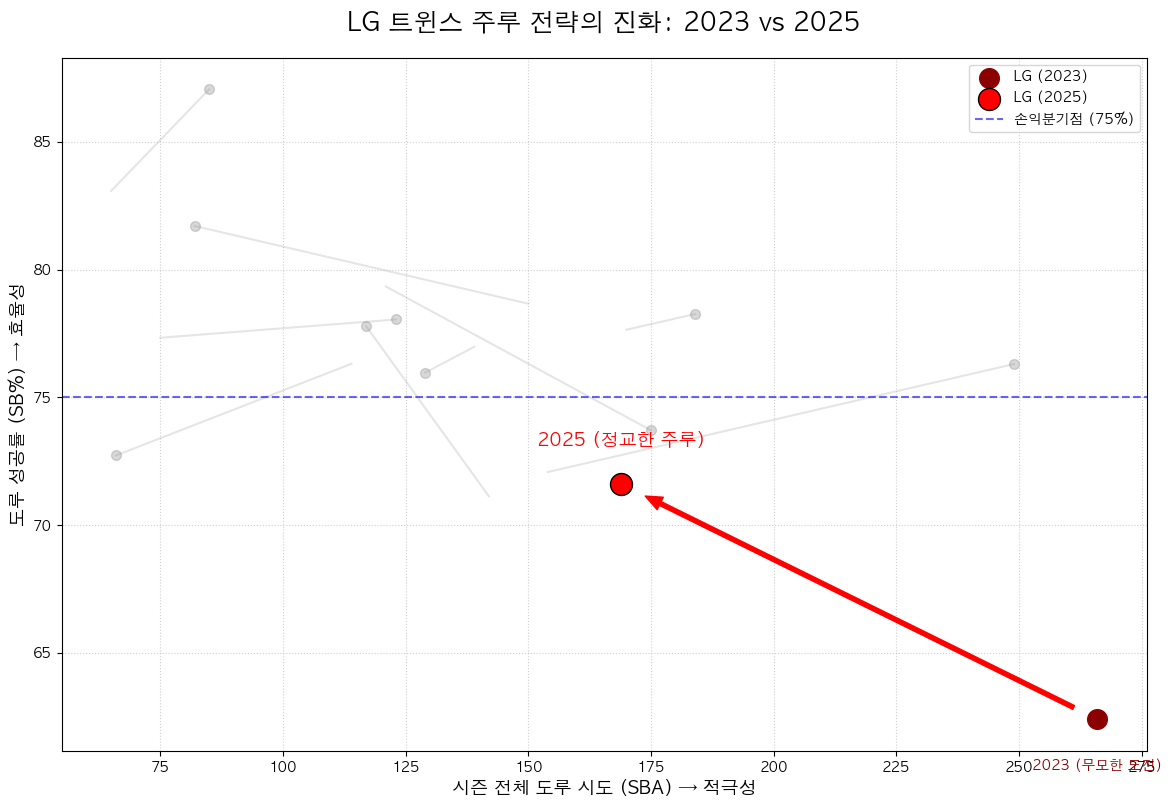

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 (앞서 저장한 파일명 확인)
df_2023 = pd.read_csv("KBO_2023_All_Runners.csv")
df_2025 = pd.read_csv("KBO_Total_Runners.csv")

# 2. 전처리 함수: 팀별 집계 및 성공률 계산
def get_team_stats(df, year):
    cols = ['SBA', 'SB', 'CS']
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    team_stats = df.groupby('팀명')[cols].sum()
    team_stats['SB%'] = (team_stats['SB'] / team_stats['SBA']) * 100
    team_stats['Year'] = year
    return team_stats

# 3. 연도별 팀 데이터 생성
team_2023 = get_team_stats(df_2023, 2023)
team_2025 = get_team_stats(df_2025, 2025)

# 4. 시각화 설정
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(14, 9))

# 4-1. 타 팀들의 이동 배경 (연한 회색 선)
for team in team_2023.index:
    if team != 'LG':
        x_coords = [team_2023.loc[team, 'SBA'], team_2025.loc[team, 'SBA']]
        y_coords = [team_2023.loc[team, 'SB%'], team_2025.loc[team, 'SB%']]
        plt.plot(x_coords, y_coords, color='gray', alpha=0.2, zorder=1)
        plt.scatter(x_coords[1], y_coords[1], color='gray', s=50, alpha=0.3)

# 4-2. LG 트윈스의 이동 강조 (두꺼운 빨간색 화살표)
lg_23 = team_2023.loc['LG']
lg_25 = team_2025.loc['LG']

plt.annotate('', xy=(lg_25['SBA'], lg_25['SB%']), xytext=(lg_23['SBA'], lg_23['SB%']),
             arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.05, width=3, headwidth=10),
             label='LG 전략 변화')

# 4-3. 지점 마킹
plt.scatter(lg_23['SBA'], lg_23['SB%'], color='darkred', s=200, label='LG (2023)', zorder=5)
plt.scatter(lg_25['SBA'], lg_25['SB%'], color='red', s=250, edgecolor='black', label='LG (2025)', zorder=5)

# 4-4. 텍스트 추가
plt.text(lg_23['SBA'], lg_23['SB%'] - 2, '2023 (무모한 도전)', color='darkred', fontweight='bold', ha='center')
plt.text(lg_25['SBA'], lg_25['SB%'] + 1.5, '2025 (정교한 주루)', color='red', fontweight='bold', ha='center', fontsize=13)

# 4-5. 가이드라인 및 꾸미기
plt.axhline(75, color='blue', linestyle='--', alpha=0.6, label='손익분기점 (75%)')
plt.title('LG 트윈스 주루 전략의 진화: 2023 vs 2025', fontsize=18, pad=20)
plt.xlabel('시즌 전체 도루 시도 (SBA) → 적극성', fontsize=13)
plt.ylabel('도루 성공률 (SB%) → 효율성', fontsize=13)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

plt.show()

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
# 2025년(현재) 전체 데이터에서 LG 선수만 골라냅니다.
df_current_all = pd.read_csv("KBO_Total_Runners.csv")
lg_25 = df_current_all[df_current_all['팀명'] == 'LG'].copy()

# 2023년 LG 선수 데이터
lg_23 = pd.read_csv("LG_2023_Runners.csv")

# 2. 데이터 전처리 (숫자 변환 및 이름 정리)
def prepare_data(df, year_suffix):
    cols = ['SBA', 'SB', 'SB%']
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df[['선수명', 'SBA', 'SB', 'SB%']].rename(columns={
        'SBA': f'시도_{year_suffix}', 
        'SB': f'성공_{year_suffix}', 
        'SB%': f'성공률_{year_suffix}'
    })

lg_23_clean = prepare_data(lg_23, '23')
lg_25_clean = prepare_data(lg_25, '25')

# 3. 선수명을 기준으로 데이터 합치기 (두 시즌 모두 기록이 있는 선수)
player_diff = pd.merge(lg_23_clean, lg_25_clean, on='선수명')

# 4. 효율성 변화 계산
player_diff['성공률_변화'] = player_diff['성공률_25'] - player_diff['성공률_23']

print("--- LG 선수별 주루 효율 변화 순위 ---")
print(player_diff.sort_values(by='성공률_변화', ascending=False).head(10))

--- LG 선수별 주루 효율 변화 순위 ---
   선수명  시도_23  성공_23  성공률_23  시도_25  성공_25  성공률_25  성공률_변화
3  홍창기     46     23    50.0      3      3   100.0    50.0
8  김현수      3      2    66.7      4      4   100.0    33.3
7  오스틴     10      7    70.0      3      3   100.0    30.0
5  문보경     17      9    52.9      4      3    75.0    22.1
1  박해민     38     26    68.4     63     49    77.8     9.4
0  신민재     54     37    68.5     24     15    62.5    -6.0
2  문성주     38     24    63.2      7      4    57.1    -6.1
4  오지환     23     16    69.6     16      9    56.3   -13.3
6  최승민     11      8    72.7      3      1    33.3   -39.4
9  송찬의      1      1   100.0      4      2    50.0   -50.0


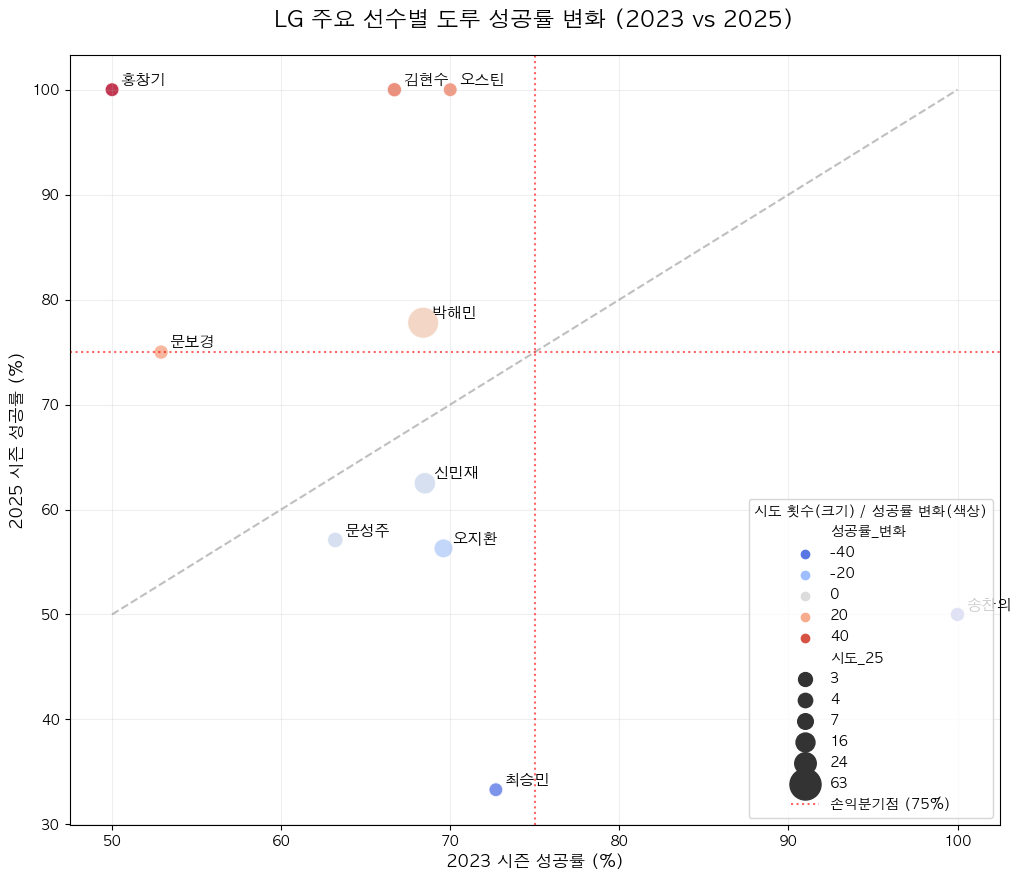

In [19]:
# 5. 시각화: 선수별 주루 효율 성장 지도
plt.rc('font', family='AppleGothic') # Mac
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12, 10))

# 기준선 (23년과 25년이 같은 경우)
plt.plot([50, 100], [50, 100], color='gray', linestyle='--', alpha=0.5)

# 선수별 점 찍기
sns.scatterplot(data=player_diff, x='성공률_23', y='성공률_25', 
                size='시도_25', sizes=(100, 500), hue='성공률_변화', 
                palette='coolwarm', alpha=0.8)

# 선수 이름 표시
for i in range(len(player_diff)):
    plt.text(player_diff.loc[i, '성공률_23'] + 0.5, 
             player_diff.loc[i, '성공률_25'] + 0.5, 
             player_diff.loc[i, '선수명'], fontsize=11)

# 손익분기점 가이드라인 (75%)
plt.axhline(75, color='red', linestyle=':', alpha=0.6, label='손익분기점 (75%)')
plt.axvline(75, color='red', linestyle=':', alpha=0.6)

plt.title('LG 주요 선수별 도루 성공률 변화 (2023 vs 2025)', fontsize=16, pad=20)
plt.xlabel('2023 시즌 성공률 (%)', fontsize=12)
plt.ylabel('2025 시즌 성공률 (%)', fontsize=12)
plt.grid(True, alpha=0.2)
plt.legend(title='시도 횟수(크기) / 성공률 변화(색상)')

plt.show()

In [20]:
import pandas as pd

# 1. 데이터 로드 및 LG 필터링
df = pd.read_csv("KBO_Total_Runners.csv")
lg_runners = df[df['팀명'] == 'LG'].copy()

# 2. 숫자 데이터 변환
cols = ['SBA', 'SB', 'CS']
for col in cols:
    lg_runners[col] = pd.to_numeric(lg_runners[col], errors='coerce')

# 3. 주루 지표 계산
# SB% (성공률)
lg_runners['SB%'] = (lg_runners['SB'] / lg_runners['SBA'] * 100).round(1)

# wSB (간이 버전: 성공 시 +0.2, 실패 시 -0.4 득점 가치 부여)
# 산업공학적 '기여도' 산출 방식
lg_runners['wSB'] = (lg_runners['SB'] * 0.2) - (lg_runners['CS'] * 0.4)

# 4. 적정 선수 분류 (최적화 모델)
def classify_runner(row):
    if row['SB%'] >= 80 and row['SBA'] >= 10:
        return 'S (Elite - 그린라이트)'
    elif row['SB%'] >= 75:
        return 'A (Good - 적극 활용)'
    elif row['SB%'] >= 65:
        return 'B (Risky - 사인 필요)'
    else:
        return 'C (Warning - 주루 억제)'

lg_runners['추천등급'] = lg_runners.apply(classify_runner, axis=1)

# 5. 최종 결과 출력 (기여도 순 정렬)
final_list = lg_runners[['선수명', 'SBA', 'SB', 'SB%', 'wSB', '추천등급']].sort_values(by='wSB', ascending=False)

print("--- [최종 분석] LG 트윈스 주루 최적화 추천 명단 ---")
print(final_list)

# 분석 결과 저장
# final_list.to_csv("LG_Baserunning_Analysis_Final.csv", index=False, encoding='utf-8-sig')

--- [최종 분석] LG 트윈스 주루 최적화 추천 명단 ---
     선수명  SBA  SB    SB%  wSB                 추천등급
0    박해민   63  49   77.8  4.2     A (Good - 적극 활용)
61   박동원    4   4  100.0  0.8     A (Good - 적극 활용)
59   김현수    4   4  100.0  0.8     A (Good - 적극 활용)
74   홍창기    3   3  100.0  0.6     A (Good - 적극 활용)
72   오스틴    3   3  100.0  0.6     A (Good - 적극 활용)
73   천성호    4   3   75.0  0.2     A (Good - 적극 활용)
71   문보경    4   3   75.0  0.2     A (Good - 적극 활용)
118  김민수    1   1  100.0  0.2     A (Good - 적극 활용)
119  손용준    1   1  100.0  0.2     A (Good - 적극 활용)
120  이영빈    1   1  100.0  0.2     A (Good - 적극 활용)
38   최원영   12   8   66.7  0.0    B (Risky - 사인 필요)
34   구본혁   15  10   66.7  0.0    B (Risky - 사인 필요)
95   송찬의    4   2   50.0 -0.4  C (Warning - 주루 억제)
60   문성주    7   4   57.1 -0.4  C (Warning - 주루 억제)
20   신민재   24  15   62.5 -0.6  C (Warning - 주루 억제)
121  최승민    3   1   33.3 -0.6  C (Warning - 주루 억제)
37   오지환   16   9   56.2 -1.0  C (Warning - 주루 억제)
